# Combined Diffusion with GAN in cycle architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import random
import pytorch_lightning as pl
from diffusers import UNet2DModel, DDPMScheduler
from pytorch_lightning.callbacks.model_summary import ModelSummary
from pytorch_lightning.utilities.model_summary import summarize
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

In [ ]:
path = "/your/path/to/directory"

In [ ]:

# Create dataset and dataloader
hazy_dir = path+"/Consolidated_Hazy_Images"
clear_dir = path+"/Consolidated_Clear_Images"

In [ ]:
class UnpairedImageDataset(Dataset):
    def __init__(self, hazy_dir, clear_dir, transform=None):
        """
        Args:
            hazy_dir (str): Directory containing hazy images
            clear_dir (str): Directory containing clear images
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.hazy_images = [os.path.join(hazy_dir, f) for f in os.listdir(hazy_dir)]
        self.clear_images = [os.path.join(clear_dir, f) for f in os.listdir(clear_dir)]
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset, which is the maximum of the number of hazy and clear images.
        """
        return max(len(self.hazy_images), len(self.clear_images))

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve

        Returns:
            tuple: A tuple containing the hazy image and clear image
        """
        hazy_img = Image.open(self.hazy_images[idx % len(self.hazy_images)]).convert('RGB')
        clear_img = Image.open(random.choice(self.clear_images)).convert('RGB')

        if self.transform:
            hazy_img = self.transform(hazy_img)
            clear_img = self.transform(clear_img)

        return hazy_img, clear_img

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = UnpairedImageDataset(hazy_dir, clear_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
    """
    Initializes the ResidualBlock module.

    Parameters
    ----------
    in_features : int
        The number of input and output features (channels) for the convolutional layers.
    """

        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        """
        Forward pass of the ResidualBlock.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor.
        """
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        """
        Initializes the Generator module.

        Parameters
        ----------
        input_nc : int
            The number of channels in the input image.
        output_nc : int
            The number of channels in the output image.
        n_residual_blocks : int, optional
            The number of residual blocks in the generator. Defaults to 9.
        """
        super(Generator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        
        """
        Forward pass of the generator.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor.
        """
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        
        """
        Parameters
        ----------
        input_nc : int
            The number of channels in the input images.

        """
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        """
        Forward pass of the discriminator network.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor.
        """
        x = self.model(x)
        return nn.functional.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [ ]:
class CycleGANDiffusion(pl.LightningModule):
    def __init__(self):
        """
        Initialize the CycleGAN diffusion model.

        The model consists of two generators, two discriminators, and a diffusion model.
        The generators are used to generate images in the target domain, the discriminators
        are used to distinguish between real and fake images, and the diffusion model is used
        to generate noise that is used to condition the generators.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        super().__init__()
        self.automatic_optimization = False
        self.G_H2C = Generator(3, 3)
        self.G_C2H = Generator(3, 3)
        self.D_H = Discriminator(3)
        self.D_C = Discriminator(3)
        self.diffusion = UNet2DModel(
            sample_size=256,
            in_channels=3,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(128, 128, 256, 256, 512, 512),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
                "AttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
        )
        self.noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()

    def forward(self, hazy):
        """
        Forward pass of the CycleGAN model.

        Parameters
        ----------
        hazy : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor.
        """
        return self.G_H2C(hazy)

    def training_step(self, batch, batch_idx):
        """
        Executes a single training step for the CycleGAN model, which includes updating
        the generator, discriminator, and diffusion model.

        Parameters
        ----------
        batch : tuple of torch.Tensor
            A tuple containing the input data for the hazy and clear domains.
        batch_idx : int
            The index of the current batch.

        Returns
        -------
        dict
            A dictionary containing the total loss combining generator, discriminator,
            and diffusion model losses.
        """

        hazy, clear = batch
        opt_g, opt_d, opt_diffusion = self.optimizers()

        # Generator update
        opt_g.zero_grad()
        # Identity loss
        loss_id_H = self.criterion_identity(self.G_C2H(clear), clear)
        loss_id_C = self.criterion_identity(self.G_H2C(hazy), hazy)
        loss_identity = (loss_id_H + loss_id_C) / 2

        # GAN loss
        fake_clear = self.G_H2C(hazy)
        pred_fake = self.D_C(fake_clear)
        loss_GAN_H2C = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_hazy = self.G_C2H(clear)
        pred_fake = self.D_H(fake_hazy)
        loss_GAN_C2H = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Cycle loss
        recovered_hazy = self.G_C2H(fake_clear)
        loss_cycle_H = self.criterion_cycle(recovered_hazy, hazy)

        recovered_clear = self.G_H2C(fake_hazy)
        loss_cycle_C = self.criterion_cycle(recovered_clear, clear)

        # Total generator loss
        loss_G = loss_identity * 5.0 + loss_GAN_H2C + loss_GAN_C2H + loss_cycle_H * 10.0 + loss_cycle_C * 10.0
        self.manual_backward(loss_G)
        opt_g.step()

        # Discriminator update
        opt_d.zero_grad()
        # Real loss
        pred_real = self.D_H(hazy)
        loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = self.D_H(fake_hazy.detach())
        loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_H = (loss_D_real + loss_D_fake) / 2

        # Real loss
        pred_real = self.D_C(clear)
        loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = self.D_C(fake_clear.detach())
        loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_C = (loss_D_real + loss_D_fake) / 2

        loss_D = (loss_D_H + loss_D_C) / 2
        self.manual_backward(loss_D)
        opt_d.step()

        # Diffusion model training
        opt_diffusion.zero_grad()
        noise = torch.randn_like(clear)
        timesteps = torch.randint(0, self.noise_scheduler.num_train_timesteps, (clear.shape[0],), device=self.device).long()
        noisy_clear = self.noise_scheduler.add_noise(clear, noise, timesteps)
        noise_pred = self.diffusion(noisy_clear, timesteps, return_dict=False)[0]
        loss_diffusion = nn.functional.mse_loss(noise_pred, noise)
        self.manual_backward(loss_diffusion)
        opt_diffusion.step()

        # Log losses
        self.log('loss_G', loss_G, on_step=True, on_epoch=True, prog_bar=True)
        self.log('loss_D', loss_D, on_step=True, on_epoch=True, prog_bar=True)
        self.log('loss_diffusion', loss_diffusion, on_step=True, on_epoch=True, prog_bar=True)

        return {"loss": loss_G + loss_D + loss_diffusion}

    def configure_optimizers(self):
        """
        Configure the optimizers for the CycleGAN model.

        Returns
        -------
        A list of three optimizers, and an empty list.
        """
        opt_g = torch.optim.Adam(list(self.G_H2C.parameters()) + list(self.G_C2H.parameters()), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(list(self.D_H.parameters()) + list(self.D_C.parameters()), lr=0.0002, betas=(0.5, 0.999))
        opt_diffusion = torch.optim.Adam(self.diffusion.parameters(), lr=1e-4)
        return [opt_g, opt_d, opt_diffusion], []

    def on_train_epoch_end(self):
        # Save the model at the end of each epoch
        """
        Save the model at the end of each epoch.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        epoch = self.current_epoch
        checkpoint_path = path+'/cyclegan_diffusion_checkpoint'+f"cyclegan_diffusion_epoch_{epoch}.ckpt"
        self.trainer.save_checkpoint(checkpoint_path)
        print(f"Model saved at epoch {epoch}")


# Training

In [ ]:
import os
import glob
from pytorch_lightning.callbacks import ModelCheckpoint

# Define the checkpoint directory
checkpoint_dir = path+'/cyclegan_diffusion_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

# Custom callback to delete previous checkpoints
class DeletePreviousCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        """
        Override the on_save_checkpoint method to delete previous checkpoints.
        
        This custom callback inherits from ModelCheckpoint and overrides the on_save_checkpoint method.
        After saving a new checkpoint, it deletes the oldest previous checkpoint.
        
        Parameters
        ----------
        trainer : pytorch_lightning.Trainer
            The trainer object.
        pl_module : pytorch_lightning.LightningModule
            The LightningModule object.
        checkpoint : dict
            The checkpoint dictionary.
        
        Returns
        -------
        None
        """
        super().on_save_checkpoint(trainer, pl_module, checkpoint)
        # Delete previous checkpoints
        checkpoints = glob.glob(os.path.join(self.dirpath, "cyclegan_diffusion_*.ckpt"))
        if len(checkpoints) > 1:
            oldest_checkpoint = min(checkpoints, key=os.path.getctime)
            os.remove(oldest_checkpoint)
            print(f"Deleted previous checkpoint: {oldest_checkpoint}")

# Create a ModelCheckpoint callback
checkpoint_callback = DeletePreviousCheckpoint(
    dirpath=checkpoint_dir,
    filename="cyclegan_diffusion-{epoch:02d}-{loss:.2f}",
    save_top_k=3,
    monitor="loss",
    mode="min",
    every_n_epochs=5,
    save_last=False  # Always save the last model
)

# Check if there are any existing checkpoints
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.ckpt')])

if checkpoints:
    # Load the latest checkpoint
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
    print(f"Resuming training from checkpoint: {latest_checkpoint}")
    model = CycleGANDiffusion.load_from_checkpoint(latest_checkpoint)
else:
    # Start with a new model if no checkpoints are found
    print("Starting training from scratch")
    model = CycleGANDiffusion()

Resuming training from checkpoint: /content/drive/MyDrive/Vikram/gen AI Project/cyclegan_diffusion_checkpoint/cyclegan_diffusion_epoch_100.ckpt


In [ ]:
# Create the trainer with the checkpoint callback
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1 if torch.cuda.is_available() else 0,
    callbacks=[checkpoint_callback]
)

print(summarize(model, max_depth=1))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


  | Name               | Type          | Params | Mode 
-------------------------------------------------------------
0 | G_H2C              | Generator     | 11.4 M | train
1 | G_C2H              | Generator     | 11.4 M | train
2 | D_H                | Discriminator | 2.8 M  | train
3 | D_C                | Discriminator | 2.8 M  | train
4 | diffusion          | UNet2DModel   | 113 M  | train
5 | criterion_GAN      | MSELoss       | 0      | train
6 | criterion_cycle    | L1Loss        | 0      | train
7 | criterion_identity | L1Loss        | 0      | train
-------------------------------------------------------------
141 M     Trainable params
0         Non-trainable params
141 M     Total params
567.836   Total estimated model params size (MB)
598       Modules in train mode
0         Modules in eval mode


In [ ]:
# Start or resume training
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


# Testing on Test Clips

In [ ]:
# for 256x256 image generation
import os
import torch
from PIL import Image
from torchvision import transforms
from pytorch_lightning import LightningModule
import numpy as np

# Assuming CycleGANDiffusion is your model class
# from your_model_file import CycleGANDiffusion

def load_latest_model(checkpoint_dir):
    """
    Load the latest model checkpoint from a directory.

    Parameters
    ----------
    checkpoint_dir : str
        The directory path containing model checkpoints.

    Returns
    -------
    str
        The path to the latest checkpoint file.

    Raises
    ------
    ValueError
        If no checkpoints are found in the directory.
    """

    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.ckpt')]
    if not checkpoints:
        raise ValueError("No checkpoints found in the directory.")
    latest_checkpoint = max(checkpoints, key=lambda x: os.path.getctime(os.path.join(checkpoint_dir, x)))
    return os.path.join(checkpoint_dir, latest_checkpoint)

def test_model(model, test_dir, output_dir):
    """
    Tests the model by generating clear images from hazy test images and saves them to the output directory.

    Parameters
    ----------
    model : nn.Module
        The trained model used for generating clear images.
    test_dir : str
        The directory containing hazy test images.
    output_dir : str
        The directory where generated clear images will be saved.

    Notes
    -----
    The function sets the model to evaluation mode and applies a series of transformations to the input images
    before passing them through the model. The generated images are then post-processed and saved in the output
    directory with the 'clear_' prefix.
    """

    model.eval()
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            hazy_img = Image.open(img_path).convert('RGB')
            hazy_tensor = test_transform(hazy_img).unsqueeze(0).to(model.device)

            clear_img = model(hazy_tensor)

            # Convert tensor to image and save
            clear_img = (clear_img.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2
            clear_img = np.clip((clear_img * 255), 0, 255).astype('uint8')
            clear_img = Image.fromarray(clear_img)
            clear_img.save(os.path.join(output_dir, f'clear_{img_name}'))

    print(f"Processed images saved in {output_dir}")

# Set up paths
checkpoint_dir = path+'/cyclegan_diffusion_checkpoint'
test_dir = path+"/Consolidated_Test_Clips"
output_dir = path+"/cyclegan_diffusion"

# Load the latest model
latest_checkpoint = load_latest_model(checkpoint_dir)
print(f"Loading model from {latest_checkpoint}")

# Load the model
model = CycleGANDiffusion.load_from_checkpoint(latest_checkpoint)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Test the model
test_model(model, test_dir, output_dir)


Loading model from /content/drive/MyDrive/Vikram/gen AI Project/cyclegan_diffusion_checkpoint/cyclegan_diffusion_epoch_100.ckpt
Processed images saved in /content/drive/MyDrive/Vikram/gen AI Project/cyclegan_diffusion


# Metrics

In [ ]:
import numpy as np
from scipy import signal

def compute_fade(image):
    # Convert image to grayscale if it's not already
    """
    Compute the FADE score of an image.

    The FADE score is a metric that measures the difference between the original
    image and the dehazed image. The score is computed as the mean of the NSS
    features of the absolute difference between the original image and its
    local mean.

    Parameters
    ----------
    image : array_like
        The image to compute the FADE score for.

    Returns
    -------
    float
        The FADE score of the image.
    """

    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Compute local contrast
    kernel = np.ones((3, 3)) / 9
    local_mean = signal.convolve2d(image, kernel, mode='same')
    local_contrast = np.abs(image - local_mean)

    # Compute NSS features
    nss_features = compute_nss_features(local_contrast)

    # Compute FADE score (this is a simplified version)
    fade_score = np.mean(nss_features)

    return fade_score

def compute_nss_features(local_contrast):
    # This is a placeholder for the actual NSS feature computation
    # In practice, this would involve more complex calculations
    """
    Compute NSS features from local contrast.

    This function is a placeholder for computing Natural Scene Statistics (NSS)
    features from the local contrast of an image. NSS features are statistical 
    measures of the image that are useful in image quality assessment and other 
    image processing tasks.

    Parameters
    ----------
    local_contrast : array_like
        The local contrast of the image, typically computed as the absolute 
        difference between the image and its local mean.

    Returns
    -------
    array_like
        The NSS features derived from the local contrast. In this placeholder, 
        it simply returns the local contrast as the NSS features.
    """

    return local_contrast

In [ ]:
import numpy as np
from scipy import ndimage

def compute_jnbm(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Compute edge map
    edge_map = compute_edge_map(image)

    # Compute local contrast
    local_contrast = compute_local_contrast(image)

    # Compute JNB at each edge pixel
    jnb = compute_jnb(local_contrast)

    # Compute blur ratio at each edge pixel
    blur_ratio = compute_blur_ratio(edge_map, jnb)

    # Compute final JNBM score
    jnbm_score = np.mean(blur_ratio)

    return jnbm_score

def compute_edge_map(image):
    # Placeholder for edge detection
    return ndimage.sobel(image)

def compute_local_contrast(image):
    # Placeholder for local contrast computation
    return np.abs(image - ndimage.uniform_filter(image, size=3))

def compute_jnb(local_contrast):
    # Placeholder for JNB computation
    return 5 / (1 + np.exp(-0.5 * local_contrast))

def compute_blur_ratio(edge_map, jnb):
    # Placeholder for blur ratio computation
    return np.where(edge_map > 0, edge_map / jnb, 0)

In [ ]:
import numpy as np
from scipy import ndimage

def compute_rea(original_image, restored_image):
    # Convert images to grayscale if they're not already
    if len(original_image.shape) == 3:
        original_image = np.mean(original_image, axis=2)
    if len(restored_image.shape) == 3:
        restored_image = np.mean(restored_image, axis=2)

    # Compute edge maps
    original_edges = compute_edge_map(original_image)
    restored_edges = compute_edge_map(restored_image)

    # Compute visible edges ratio
    visible_edges_ratio = compute_visible_edges_ratio(original_edges, restored_edges)

    # Compute REA score
    rea_score = np.mean(visible_edges_ratio)

    return rea_score

def compute_edge_map(image):
    # Placeholder for edge detection
    return ndimage.sobel(image)

def compute_visible_edges_ratio(original_edges, restored_edges):
    # Placeholder for visible edges ratio computation
    return np.where(original_edges > 0, restored_edges / original_edges, 0)

In [ ]:
import os
import numpy as np
from skimage import io
import cv2
from PIL import Image

def calculate_metrics(original_path, generated_path):
    fade_values = []
    jnbm_values = []
    rea_values = []

    # Iterate through the images in both directories
    for filename in os.listdir(original_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Read the original and generated images
            original_img = io.imread(os.path.join(original_path, filename))
            generated_img = io.imread(os.path.join(generated_path, f'clear_{filename}'))

            # Convert NumPy array to PIL Image for resizing
            original_img_pil = Image.fromarray(original_img)
            generated_img_pil = Image.fromarray(generated_img)

            # Resize images to 256x256
            original_img_resized = original_img_pil.resize((256, 256))
            generated_img_resized = generated_img_pil.resize((256, 256))

            # Convert images back to NumPy arrays
            original_img_resized = np.array(original_img_resized)
            generated_img_resized = np.array(generated_img_resized)

            # Convert images to grayscale if they're not already
            if len(original_img_resized.shape) == 3:
                original_img_resized = cv2.cvtColor(original_img_resized, cv2.COLOR_RGB2GRAY)
            if len(generated_img_resized.shape) == 3:
                generated_img_resized = cv2.cvtColor(generated_img_resized, cv2.COLOR_RGB2GRAY)

            # Calculate metrics
            fade = compute_fade(generated_img_resized)
            jnbm = compute_jnbm(generated_img_resized)
            rea = compute_rea(original_img_resized, generated_img_resized)

            # Append values to lists
            fade_values.append(fade)
            jnbm_values.append(jnbm)
            rea_values.append(rea)

    # Calculate averages
    avg_fade = np.mean(fade_values)
    avg_jnbm = np.mean(jnbm_values)
    avg_rea = np.mean(rea_values)

    return avg_fade, avg_jnbm, avg_rea

# Paths to the original and generated image directories
original_path = path+"/Consolidated_Test_Clips"
generated_path = path+"/cyclegan_diffusion"

# Calculate average metrics
avg_fade, avg_jnbm, avg_rea = calculate_metrics(original_path, generated_path)

print(f"Average FADE: {avg_fade:.4f}")
print(f"Average JNBM: {avg_jnbm:.4f}")
print(f"Average REA: {avg_rea:.4f}")


Average FADE: 2.1674
Average JNBM: 24.984
Average REA: 9.8


# Demo on one image

Give the path to the hazy image: /content/drive/MyDrive/Vikram/gen AI Project/Consolidated_Hazy_Images/TLH_10_TLH_10_1002.png
Give the output directory: /content
Processed image saved as /content/clear_TLH_10_TLH_10_1002.png


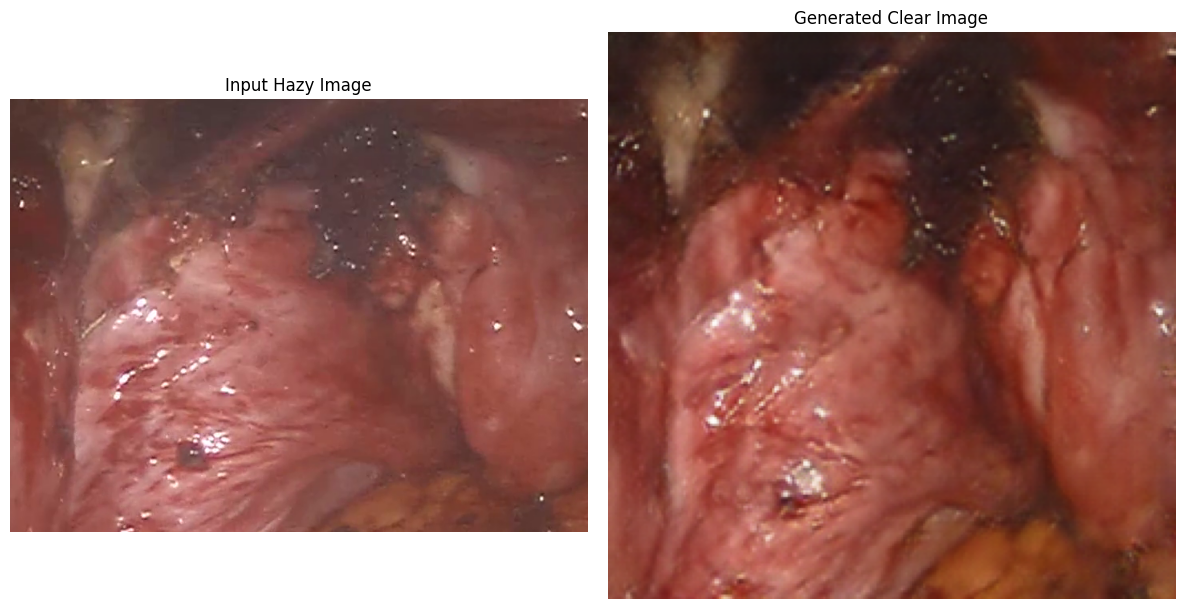

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

def process_single_image(model, input_path, output_dir):
    model.eval()
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        hazy_img = Image.open(input_path).convert('RGB')
        hazy_tensor = test_transform(hazy_img).unsqueeze(0).to(model.device)

        clear_img = model(hazy_tensor)

        # Convert tensor to image
        clear_img_np = (clear_img.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2
        clear_img_np = np.clip((clear_img_np * 255), 0, 255).astype('uint8')
        clear_img_pil = Image.fromarray(clear_img_np)

        # Save the output image
        output_filename = f'clear_{os.path.basename(input_path)}'
        output_path = os.path.join(output_dir, output_filename)
        clear_img_pil.save(output_path)

        print(f"Processed image saved as {output_path}")

        # Display input and output images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(hazy_img)
        plt.title("Input Hazy Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(clear_img_np)
        plt.title("Generated Clear Image")
        plt.axis('off')

        plt.tight_layout()

    return clear_img_pil, plt.gcf()  # Return the figure instead of showing it


input_path = input("Give the path to the hazy image: ")
output_dir = input("Give the output directory: ")

clear_img, fig = process_single_image(model, input_path, output_dir)
plt.show()